In [47]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#outlier detection
from sklearn.ensemble import IsolationForest

#score
from sklearn.metrics import f1_score

# removes warnings in output
import warnings
warnings.filterwarnings("ignore")

In [48]:
#import data
training=pd.read_csv('training_data.csv', sep=',')
test=pd.read_csv('songs_to_classify.csv', sep=',')
training.sample(5)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
472,0.00016,0.520,255000,0.953,0.651000,0,0.3540,-4.527,1,0.0548,127.968,4,0.573,0
670,0.14200,0.768,247040,0.768,0.000000,0,0.0664,-6.699,1,0.2530,136.943,4,0.465,0
674,0.49100,0.655,237013,0.405,0.000411,7,0.0664,-15.219,1,0.0360,82.218,4,0.841,1
413,0.14500,0.595,225813,0.520,0.000000,11,0.1170,-8.185,0,0.0414,79.950,4,0.369,1
31,0.82900,0.584,139067,0.428,0.848000,5,0.1070,-14.283,1,0.0293,111.570,4,0.593,1


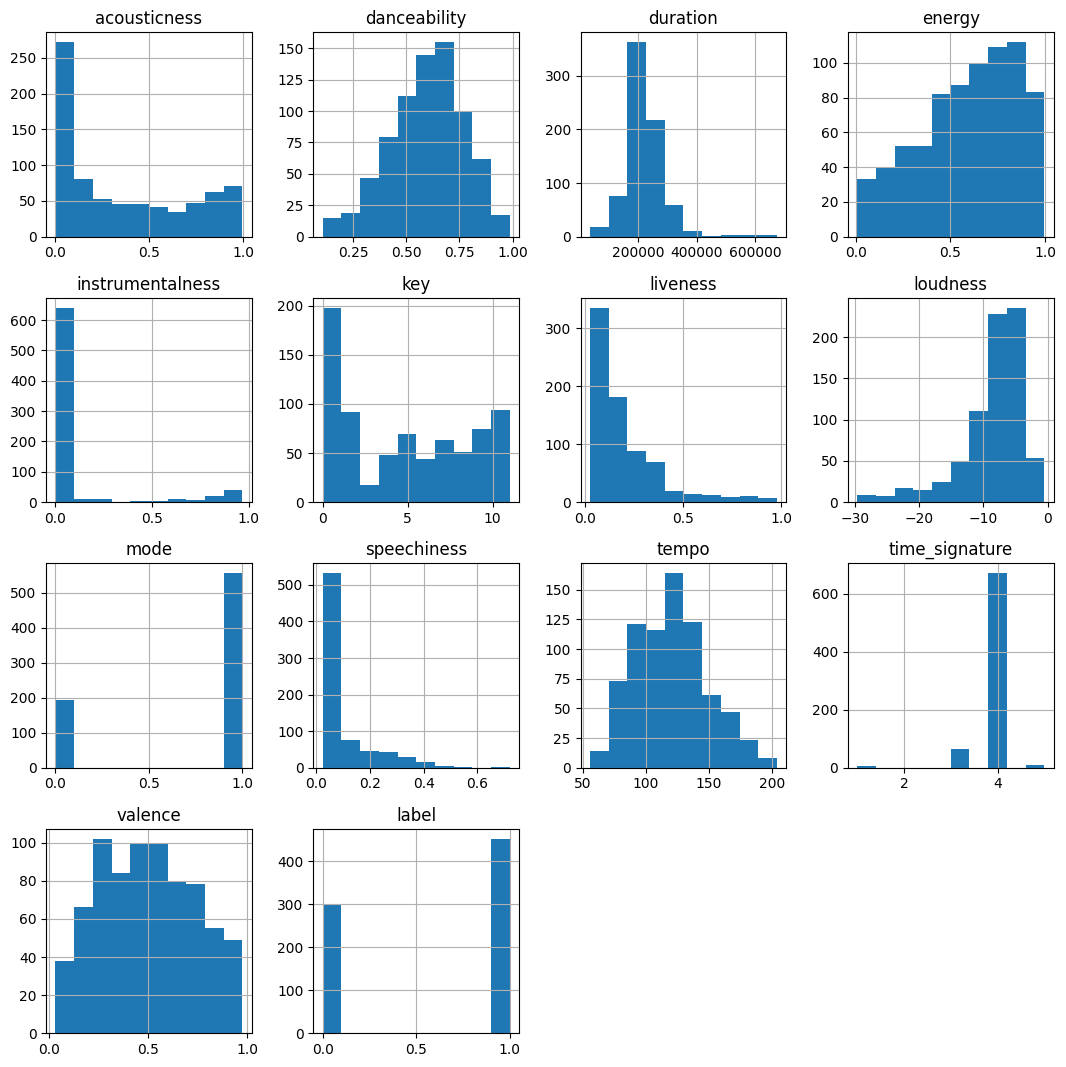

In [49]:
#visualize data
training.hist(figsize=(13,13));

From the above table, time_signature and instrumentalness are prevalent with a specific value throughout the data, and thus doesn't impact predictions

In [50]:
#remove time_signature and instrumentalness from the data
feature_selection = [0,1,2,3,5,6,7,8,9,10,12]
training.iloc[:,feature_selection]

,acousticness,danceability,duration,energy,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.713000,0.514,100125,0.521,8,0.1120,-14.835,0,0.0444,119.879,0.143
1,0.192000,0.714,207019,0.614,4,0.2630,-6.935,1,0.0319,123.969,0.582
2,0.333000,0.630,216200,0.455,5,0.1270,-9.290,1,0.0292,139.931,0.199
3,0.601000,0.810,136413,0.221,5,0.1840,-11.005,1,0.0429,109.960,0.798
4,0.883000,0.465,181440,0.459,6,0.0692,-8.137,0,0.0351,90.807,0.288
...,...,...,...,...,...,...,...,...,...,...,...
745,0.000175,0.374,333827,0.943,6,0.1250,-4.108,0,0.0556,112.084,0.338
746,0.001970,0.487,213000,0.867,10,0.0968,-3.293,0,0.0543,160.048,0.403
747,0.916000,0.605,125867,0.314,0,0.3590,-7.631,1,0.0327,138.148,0.836
748,0.168000,0.700,249493,0.823,3,0.1220,-6.892,1,0.0373,144.060,0.745


The data has alot of outliers that stray away from the rest of the group. At this point, I asked ChatGPT for tips on strategies to detect and remove these outliers. The solution I went for was using IsolationForest.

Text(0.5, 0.98, 'After')

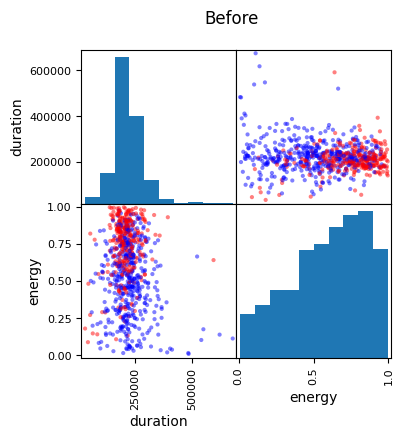

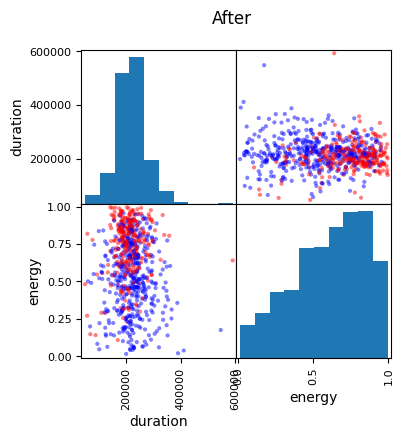

In [51]:
model = IsolationForest(contamination=0.04, random_state=42,  n_jobs=-1)
outliers = model.fit_predict(training) #returns an array containing -1 or 1's, indicating outliers or inliners
cleaned_data = training[outliers == 1] #keep only inliers

#plot training data
cols = list(map(lambda x: "red" if x == 0 else "blue", training.iloc[:,13]))
pd.plotting.scatter_matrix(training.iloc[:,2:4], c=cols, figsize=(4, 4));
plt.suptitle('Before')

#plot cleaned data
cols = list(map(lambda x: "red" if x == 0 else "blue", cleaned_data.iloc[:,13]))
pd.plotting.scatter_matrix(cleaned_data.iloc[:,2:4], c=cols, figsize=(4, 4));
plt.suptitle('After')

In [52]:
#split data into training and validation sets
# x_dummy and y_dummy are temporary variables for the train_test_split(), these variables are temporary and should be ignored

feature_selection = [0,1,2,3,5,6,7,8,9,10,12]

X, y = training.iloc[:, feature_selection], training.loc[:,'label'].values
x_dummy, x_test, y_dummy, y_test = train_test_split(X, y, test_size=0.30, random_state=42) #validation data from training data with outliers

X, y = cleaned_data.iloc[:, feature_selection], cleaned_data.loc[:,'label'].values
x_train, x_dummy, y_train, y_dummy = train_test_split(X, y, test_size=0.30, random_state=42) #test data from training data without outliers

Creating a test set with outliers will simulate more realistic data. The training however should not be affected by outliers, hence the split order.

In [53]:
#test all methods
base_estimator = DecisionTreeClassifier()
rng = np.random.RandomState(0)

classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(estimator=base_estimator, n_estimators=1000, learning_rate=1.0, random_state=rng)
    ]

#train, regularize and test F1 score
for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    print(clf, f1)

RandomForestClassifier() 0.9714285714285714
AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=1000,
                   random_state=RandomState(MT19937) at 0x2EAB6EF9840) 0.9157509157509157


From these tests, it shows that RandomForestClassifier gives the best score. Next step is to optimize parameters. This step took a LONG time, but by setting n_jobs = -1 python can use all processor cores to simultaneously train several trees. This significantly increased processing efficiency. Throughout the process, I tested several parameters and the setup which generated my best score was lost, but generally this was the strategy to find the optimal parameters.

RandomForestClassifier has a built in property 'feature_importances_', this can tell us more if we can exclude more features

In [54]:
feature_selection = [0,1,2,3,5,6,7,8,9,10,12]
training.iloc[:,feature_selection]

rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, max_samples=0.6, n_estimators=10000, random_state=rng, max_features= 'log2', n_jobs = -1, warm_start = True)
clf.fit(x_train, y_train)
print(clf.feature_importances_)

#print the training data for comparison
feature_selection = [0,1,2,3,5,6,7,8,9,10,12]
training.iloc[:,feature_selection]

[0.14630077 0.10151457 0.0641692  0.10228099 0.03341557 0.05785219
 0.13255497 0.00686378 0.23579995 0.05965599 0.05959201]


,acousticness,danceability,duration,energy,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.713000,0.514,100125,0.521,8,0.1120,-14.835,0,0.0444,119.879,0.143
1,0.192000,0.714,207019,0.614,4,0.2630,-6.935,1,0.0319,123.969,0.582
2,0.333000,0.630,216200,0.455,5,0.1270,-9.290,1,0.0292,139.931,0.199
3,0.601000,0.810,136413,0.221,5,0.1840,-11.005,1,0.0429,109.960,0.798
4,0.883000,0.465,181440,0.459,6,0.0692,-8.137,0,0.0351,90.807,0.288
...,...,...,...,...,...,...,...,...,...,...,...
745,0.000175,0.374,333827,0.943,6,0.1250,-4.108,0,0.0556,112.084,0.338
746,0.001970,0.487,213000,0.867,10,0.0968,-3.293,0,0.0543,160.048,0.403
747,0.916000,0.605,125867,0.314,0,0.3590,-7.631,1,0.0327,138.148,0.836
748,0.168000,0.700,249493,0.823,3,0.1220,-6.892,1,0.0373,144.060,0.745


In the results above we can see that mode has a low impact on the results, future feature selections will exclude mode.

Now the outliers has been removed, feature selection has been made and the classification method to optimize has been decided. By using GridSearch, the optimal parameters for RandomForest can be found. This however, takes a long time. Feel free to uncomment this section and try it yourself. (Mark everything, press Ctrl+K and afterwards Ctrl+U)

In [55]:
# clf = RandomForestClassifier()

# test = np.arange(0.1,1.0,0.2).tolist()

# param_grid = {
#     'n_estimators': [100],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'class_weight': [None, 'balanced'],
#     'max_features': test,
#     'max_samples': test,
#     'n_jobs': [-1],
#     'random_state': [rng],
#     'warm_start': [False, True]
#     }

# search = GridSearchCV(clf, param_grid, cv=5, verbose=1, scoring='f1')

# search.fit(x_train, y_train)
# score = search.score(x_test, y_test)
# print("Best CV score: {} using {}".format(search.best_score_, search.best_params_))
# print("Test accuracy: {}".format(score))

In [56]:
# the optimal parameters are tested

rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, max_samples=0.6, n_estimators=10000, random_state=rng, max_features= 'log2', n_jobs = -1, warm_start = True)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print('{0:.4f}'.format(score))

y_pred = clf.predict(x_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.9689
0.974910394265233


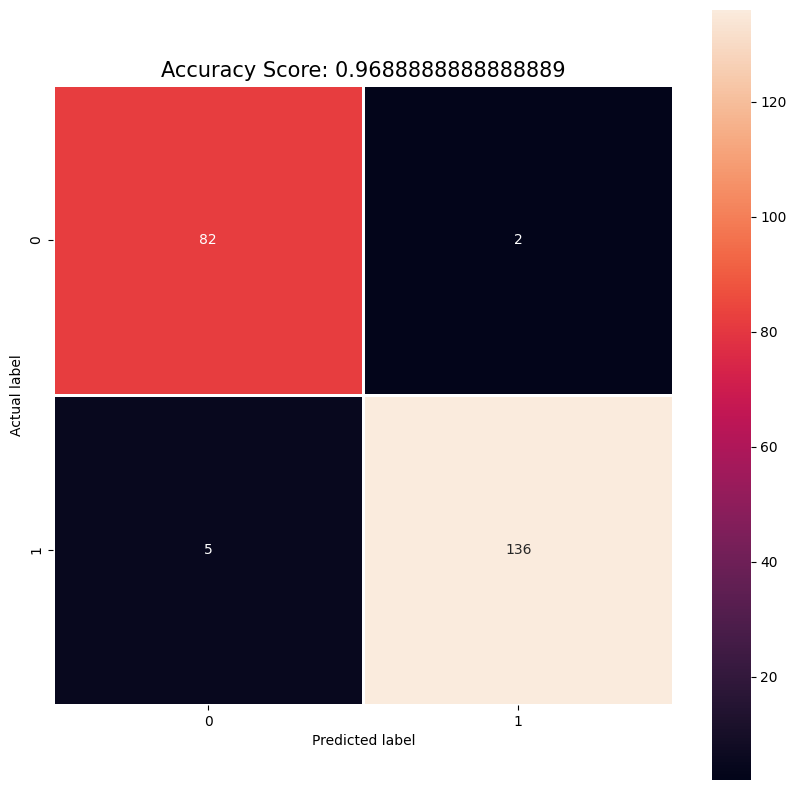

In [57]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
score = clf.score(x_test, y_test)
plt.title('Accuracy Score: {0}'.format(score), size = 15);

In [58]:
# retrain the model using the whole dataset

training=pd.read_csv('training_data.csv', sep=',')

feature_selection = ['acousticness','danceability','duration','energy','key','liveness','loudness','speechiness','tempo','valence']
x_train = training.loc[:,feature_selection].values
y_train = training.loc[:,'label'].values

rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, max_samples=0.6, n_estimators=10000, random_state=rng, max_features= 'log2', n_jobs = -1, warm_start = True)
clf.fit(x_train, y_train)

RandomForestClassifier(max_features='log2', max_samples=0.6, n_estimators=10000,
                       n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x2EAB6C6A340,
                       warm_start=True)

In [59]:
# now predict the values for the competition
x_test = test.loc[:,feature_selection].values
result = clf.predict(x_test).tolist()
file = open('finalpredictions.txt','w')
for prediction in result:
	file.write(str(prediction))
file.close()